# Глубинное обучение для текстовых данных, ФКН ВШЭ
## Домашнее задание 5: Retrieval‑Augmented Generation (RAG)
### Оценивание и штрафы

Максимально допустимая оценка за работу — __10 баллов__.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Весь код должен быть написан самостоятельно. Чужим кодом для пользоваться запрещается даже с указанием ссылки на источник. В разумных рамках, конечно. Взять пару очевидных строчек кода для реализации какого-то небольшого функционала можно.

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

__Мягкий дедлайн 16.12.24 23:59__ \
__Жесткий дедлайн 19.12.24 23:59__

### О задании

В этом домашнем задании вам предлагается реализовать ассистента для кулинарных советов с помощью RAG, который помимо всего прочего может ходить в итернет за дополнительной информацией. Всю логику системы нужно будет написать самостоятельно без специализорованных библиотек. Мы разделили ее на несколько логических компонент, каждой из которых будет отведено отдельное задание:
1. Векторная база данных с быстрым семантическим поиском
2. Разбиение текстов на куски.
3. Ранжирование документов по релевантности
4. Формирование контекста для модели и генерация ответа

### О данных

В качестве базы данных мы будем использовать пользовательские рецепты с сайта "Поваренок.Ру". Они получены с помощью веб-парсинга сайта, поэтому местами тексты недостаточно чистые. Всего в датасете содержится 84130 рецептов.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

### Загрузка датасета и модели

Таблица с рецептами хранится в файле `povarenok.csv`. Каждая запись содержит название рецепта, список ингредиентов и сам рецепт. Несмотря на то, что всего датасете хранится 84130 записей, в рамках этого задания мы будем работать с первыми 10-ю тысячами для того, чтобы все работало быстрее. При желании вы можете взять больше.

In [2]:
%pip install gdown


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import gdown

gdown.download(id='1wu38NuHL7ZxcHYxlEtWQKeouJ5zPpR4S')

Downloading...
From: https://drive.google.com/uc?id=1wu38NuHL7ZxcHYxlEtWQKeouJ5zPpR4S
To: /home/boris/Documents/ВШЭ 4 курс/nlp/hw5-rag/povarenok.csv
100%|██████████| 79.3M/79.3M [00:03<00:00, 24.4MB/s]


'povarenok.csv'

In [6]:
# %pip install datasets

In [7]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files=['povarenok.csv'], split='train')
dataset = dataset.select(range(10000))
dataset

Dataset({
    features: ['name', 'ingredients', 'text'],
    num_rows: 10000
})

In [8]:
dataset[0]

{'name': 'Густой молочно-клубничный коктейль',
 'ingredients': "['Молоко', 'Клубника', 'Сахар']",
 'text': 'Не размораживая, ягоду положите в блендер, добавьте молоко и сахар (если ягода свежая, то и перепелиное яйцо) Взбивайте на высокой скорости до полного измельчения ягод. Вылете в стаканы и можно по чуть-чуть пить, так как этот напиток оочень холодный. Кто не любит таковой, подождите и выпейте, когда он немного согреется. Приятного аппетита!'}

Посмотрим на распределение длин текстов. Нам важно знать с чем мы имеем дело, ведь RAG подразумевает, что мы будем подавать тексты на вход модели.

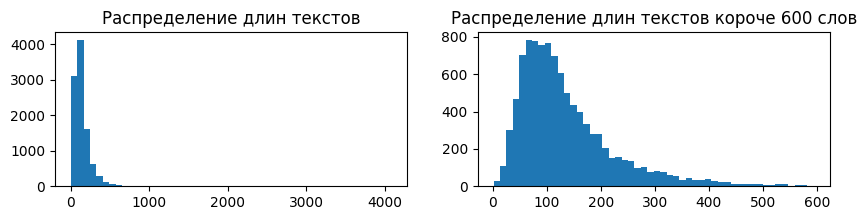

In [9]:
lens = np.array([len(dataset[i]['text'].split()) for i in range(len(dataset))])

plt.figure(figsize=(10, 2))
plt.subplot(1, 2, 1)
plt.hist(lens, bins=50)
plt.title('Распределение длин текстов')

plt.subplot(1, 2, 2)
plt.hist(lens[lens < 600], bins=50)
plt.title('Распределение длин текстов короче 600 слов')

plt.show()

Видим, что тексты часто довольно длинные. Поэтому смухлевать не получится и перед векторизацией нужно будет разбивать каждый текст на небольшие куски, чтобы не перегружать контекст модели и чтобы потерять важную информацию при векторизацци текстов на этапе складывания их в векторную базу данных.

Приступим к реализации RAG.

## Retrieval‑Augmented Generation

В качестве основы для ассистента возьмите модель [`Qwen/Qwen2-1.5B-Instruct`](https://huggingface.co/Qwen/Qwen2-1.5B-Instruct) из huggingface. Важно, что это `Instruct` модель, то есть она предлазначена для общения в формате диалога.

__Задание 0 (0 баллов).__ Проверьте, как модель отвечает на кулинарные вопросы без RAG. Это необходимо сделать, чтобы понять, нужен ли вообще RAG для данной задачи.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
device = "cuda"

model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2-1.5B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-1.5B-Instruct")

def infer_model(prompt):
    messages = [
        {"role": "system", "content": "Ты — опытный кулинарный эксперт и информационный ресурс по всем вопросам, связанным с приготовлением пищи. Ты также можешь отвечать на вопросы о кулинарных техниках, ингредиентах, оборудовании, хранении продуктов и любых других темах, связанных с кулинарией.  Твои ответы должны быть точными, информативными и понятными."},
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(device)

    generated_ids = model.generate(
        model_inputs.input_ids,
        max_new_tokens=512
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return response


In [9]:
print(infer_model("Запеченая утка"))

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Запеченные утки - это вкусная и нежная кулинарная особенность. Вот несколько простых шагов, которые помогут вам сделать их:

**Ингредиенты:**

- 1 курица (или другие виды мяса)
- 2 стакана воды
- Соль, перец по вкусу
- Зелень для украшения (например, петрушка или луковички)

**Рецепт:**

1. Нарезьте мясо тонкими дольками.
2. В большой миске смешайте воду и добавьте в нее мясо, а затем все добавьте в котleta. Поместите в кастрюлю и доведите до кипения.
3. Залейте водой и обложите крышкой. Оставьте на слабом огне около 40 минут или до полной готовности.
4. Уберите изо кастрюли и дайте ему немного отдохнуть.
5. Заверните каждый кусок в фольгу и запекайте в духовке при температуре 180 градусов Цельсия примерно 2 часа.

Это будет замечательным блюдом для праздничного стола или просто как приятное угощение. Если вы хотите добавить больше зелени, можете использовать чеснок, морковь или лук, которые будут прекрасно сочетаться с мясом. 

Помните, что время приготовления может меняться в зависим

In [10]:
print(infer_model("Селдь под шубой"))

Селдий (или сельдь) - это очень вкусное и питательное мясо, которое часто готовится в виде "под шубой". Этот метод приготовления позволяет сохранить максимум свежести мяса и улучшает его текстуру.

Вот как вы можете сделать селдий под шубой:

Ингредиенты:
- 1 килограмм селедки
- 3 зубчика чеснока
- 2 столовые ложки соли
- 1 столовая ложка муки
- 2 столовые ложки сахара
- 1 столовая ложка меда

Приготовление:
1. Нарежьте селедку на небольшие кусочки.
2. В большой миске смешайте соль, сахар, муку и мед. 
3. Добавьте натертое чесноком и перемешайте до получения однородной массы.
4. Смешанную массу выложите на селедку и аккуратно перемешайте. 
5. Запекайте в духовке на среднем огне около 30 минут или пока не станет достаточно мягким для поглощения соленого соуса.
6. Выньте селдий из духовки и дайте ему немного остыть перед подачей.

Этот рецепт подходит для использования даже в домашних условиях, если есть доступ к хорошему магазину соленого соуса. Это очень вкусное и простое блюдо, которо

In [15]:
print(infer_model("Говядина с брокколи"))

Вы хотите готовить говядину с брокколи? Вот несколько простых шагов:

1. **Подготовка ингредиентов**: 

   - Говядина (обычно используется жареная или запеченная). Вы можете использовать мясо любой степени готовности.
   - Брокколи. Это может быть свежее или вареное брокколи.
   - Лук. Чешуйчатый или белый лук.
   - Соль и перец по вкусу.
   - Масло для обжаривания.

2. **Поместите брокколи в воде для варки, пока не станет мягким.**

3. **Сначала обжарьте лук в масле. Это поможет ему стать более сочным и подчеркнет его аромат. Держите его на медленном огне до тех пор, пока он не станет прозрачным.**

4. **Время от времени помешивайте, чтобы избежать образования комков. Постепенно добавляйте мясо и продолжайте обжаривать до тех пор, пока оно не станет достаточно прожаренным. Важно, чтобы мясо было достаточно мягким, чтобы оно легко было разрезать на кусочки, но не слишком мягким, чтобы оно не было твердым после того, как оно будет приготовлено.**

5. **Добавьте варенное брокколи и продо

In [9]:
test_recipe_names = ["Запеченая утка", "Селдь под шубой", "Говядина с брокколи"]

Можно заметить, что в ответах модели иногда встречается китайский язык, в примере с борщем она сильно наврала, в последнем примере она отказалась генерировать рецепт. Думаю раг тут однозначно будет полезен.

### Locality Sensitive Hashing (LSH)

В RAG для каждого запроса необходимо искать релевантные документы по векторной базе данных. Так как документов очень много, подсчет релевантности для каждого из них будет занимать очень много времени. Поэтому нам важно, чтобы поиск был быстрым. Для достижения этого мы даже готовы немного пожертвовать точностью.

В этой секции вам предстоит реализовать [Locality Sensitive Hashing](https://ru.wikipedia.org/wiki/Locality-sensitive_hashing).

Идея LSH довольна проста. Разделим все векторы из базы данных на группы, состоящие из похожих векторов. В начале поиска определим группу, которая соответствует вектору запроса и будем считать релевантность только для объектов из этой группы. Для разбиения на группы мы введем несколько хеш-функций. Каждая их них будет строиться по следующему алгоритму:
1. Сгенерируем $k$ случайных векторов (векторы нормали гиперплоскости)
2. Для отдельной точки (вектора) в базе данных и вектора нормали запишем 1, если точка лежит над соответствующей гиперплоскостью. В обратном случае запишем 0.
3. Повторим процедуру для всех точек и векторов нормали. Так мы для каждой точки получим список из $k$ 0 и 1, который и будет хешем.
4. Запишем в хеш-таблицу найденные точки для каждого хеша.
5. Повторим шаги 1-4 $L$ раз и получим $L$ разных хеш-таблиц.

Теперь для каждого нового вектора $q$ мы можем очень быстро найти набор векторов похожих на него. Для этого посчитаем хеши запроса в каждой хеш-таблице и возьмем все точки, у которых хеш совпал c $q$ хотя бы в одной из них. Затем переранжируем найденные точки по релевантности (расстоянию до вектора запроса) и оставим заданное число самых близких.

Сложность формирования хеш-таблиц можно оценить как $O(nLkd)$, где $n$ – число векторов в базе данных, а $d$ – размерность вектора. В то же время сложность поиска LSH – $O(Lkd + (nLp) \cdot d)$, где $p$ – вероятность того, что хеш двух случайных точек совпадет ($p$ стремится к 0). Сложность полного перебора – $O(nd)$, поэтому при поиске LSH работает быстрее почти в $\frac{n}{Lk}$ раз!

__Задание 1 (3 балла).__ Реализуйте векторную базу данных LSH поиском. База данных должна уметь добавлять новые векторы, а так же по входному вектору быстро находить ближайшие к нему. Во время создании базы данных сгенерируйте необходимое число хеш-функций. Подумайте о том, как выбрать количество хеш-таблиц и число случайных векторов, а так же о том, из какого распределения брать эти случайные векторы. При добавлении нового вектора в базу данных, считайте для него хеш и записывайте, каким группам от принадлежит.

Постарайтесь оптимизировать код и не забудьте протестировать, что ваш LSH работает так, как надо. Проще всего это сделать, построив базу данных с точками на двумерной плоскости. Также сравните скорость LSH поиска с полным перебором. Если вы все сделали правильно, то для 1000 точек вы должны получить ускорение поиска примерно в 4 раза.

In [ ]:
import numpy as np
from collections import defaultdict

class LSHDatabase:
    def __init__(self, num_tables, num_hashes, vector_dim):
        self.num_tables = num_tables
        self.num_hashes = num_hashes
        self.vector_dim = vector_dim
        self.hash_tables = [defaultdict(list) for _ in range(num_tables)]
        self.random_vectors = [np.random.randn(num_hashes, vector_dim) for _ in range(num_tables)]
        self.data = []

    def _hash(self, vector, random_vectors):
        projections = np.dot(random_vectors, vector)
        return ''.join(['1' if p > 0 else '0' for p in projections])

    def add(self, vector):
        self.data.append(vector)
        for i in range(self.num_tables):
            hash_value = self._hash(vector, self.random_vectors[i])
            self.hash_tables[i][hash_value].append(len(self.data) - 1)

    def query(self, query_vector, max_dist=1, num_neighbors=5):
        candidates = set()
        for i in range(self.num_tables):
            hash_value = self._hash(query_vector, self.random_vectors[i])
            candidates.update(self.hash_tables[i].get(hash_value, []))

        candidates = list(candidates)
        distances = [np.linalg.norm(self.data[idx] - query_vector) for idx in candidates]
        sorted_neighbors = sorted(zip(candidates, distances), key=lambda x: x[1])
        return [idx for idx, dist in sorted_neighbors[:num_neighbors] if dist < max_dist]


In [11]:
import time

vector_dim = 2
data = np.random.rand(1000, vector_dim)
lsh = LSHDatabase(num_tables=5, num_hashes=50, vector_dim=vector_dim)

for vector in data:
    lsh.add(vector)

query_vector = np.random.rand(vector_dim)


start_full = time.time()
distances = [np.linalg.norm(vector - query_vector) for vector in data]
nearest_neighbors_full = np.argsort(distances)[:5]
end_full = time.time()


start_lsh = time.time()
nearest_neighbors_lsh = lsh.query(query_vector, num_neighbors=5)
end_lsh = time.time()

print("Ближайшие соседи (полный перебор):", nearest_neighbors_full)
print("Ближайшие соседи (LSH):", nearest_neighbors_lsh)
print("Время полного перебора: {:.4f} с".format(end_full - start_full))
print("Время поиска LSH: {:.4f} с".format(end_lsh - start_lsh))


Ближайшие соседи (полный перебор): [  1 587 148 688  65]
Ближайшие соседи (LSH): [1, 587, 148, 688, 65]
Время полного перебора: 0.0045 с
Время поиска LSH: 0.0013 с


Как раз видим выигрышь в скорости примерно в 4 раза.

### Разбиение текста на куски

Так как некоторые тексты довольно длинные, если мы будем кодировать их целиком одним вектором, то часть информации потеряется. Вектор все таки имеет ограниченный размер. Чтобы не терять информацию, мы поделим текст на куски и будем кодировать каждый кусок отдельно.

__Задание 2 (2 балла).__ Реализуйте [рекурсивное разбиение](https://dev.to/eteimz/understanding-langchains-recursivecharactertextsplitter-2846) текста с уровнями `["\n\n", "\n", " ", ""]`. Добавьте пересечение между кусками для уровней `[" ", ""]`. То есть если целый абзац помещается в один кусок, то пересекать его ни с чем не надо (в нем содержится законченная мысль), а если абзац не влезает и его приходится делить по словам (или символам), то нужно добавить пересечение со словами из соседних кусков того же абзаца.

Значения для максимального размера каждого куска и длины пересечения выберите самостоятельно. Надежнее всего брать размер пересечения равным половине длины куска.

In [12]:
def recursive_split(text, max_chunk_size, levels=["\n\n", "\n", " ", ""]):
    if len(text) <= max_chunk_size:
        return [text]

    delimiter = levels[0]

    if delimiter:
        chunks = text.split(delimiter)
    else:
        chunks = list(text)

    result = []
    current_chunk = ""

    for i, chunk in enumerate(chunks):
        if len(current_chunk) + len(chunk) + len(delimiter) <= max_chunk_size:
            current_chunk += (delimiter if current_chunk else "") + chunk
        else:
            if current_chunk:
                result.append(current_chunk)
            current_chunk = chunk

    if current_chunk:
        result.append(current_chunk)

    overlap_size = max_chunk_size // 2
    if levels[0] in [" ", ""]:
        for i in range(1, len(result)):
            overlap = result[i - 1][-overlap_size:] + delimiter + result[i][:overlap_size - 1]
            result.append(overlap)

    final_result = []
    for chunk in result:
        final_result.extend(recursive_split(chunk, max_chunk_size, levels[1:]))
    return final_result

In [13]:
text = """12345 12345 1234512345
6789 6798 6789"""

chunks = recursive_split(text, 12)
print("Количество кусков:", len(chunks))
for i, chunk in enumerate(chunks):
    print(f"Кусок {i + 1}:\n{chunk}\n")


Количество кусков: 6
Кусок 1:
12345 12345

Кусок 2:
1234512345

Кусок 3:
 12345 12345

Кусок 4:
6789 6798

Кусок 5:
6789

Кусок 6:
9 6798 6789



## RAG

Наконец мы можем начать собирать систему RAG. Для начала соберем векторую базу данных из кусков рецептов. Для получения эмбеддингов текстов возьмите модель [`intfloat/multilingual-e5-large`](https://huggingface.co/intfloat/multilingual-e5-large), она создана специально для этой задачи и хорошо работает с русским языком.

__Задание 3 (1 балл).__ Соберите векторую базу данных с помощью написанных вами функций. Процесс не должен занимать много времени с GPU, но мы рекомендуем сохранить результат на диск, чтобы не векторизовать весь датасет заново при перезапуске ядра. Проверьте, что по запросу возвращаются релевантные тексты.

In [11]:
# %pip install sentence_transformers

In [ ]:
from sentence_transformers import SentenceTransformer
embed_model = SentenceTransformer('intfloat/multilingual-e5-large')

In [ ]:
input_texts = []
chunked_texts2 = []
for sample in dataset:
  pre_chunks = recursive_split(sample["text"], 512)
  chunks = [chunk for chunk in pre_chunks if len(chunk) > 50 and 'forum.povarenok.ru' not in chunk]

  for chunk in chunks:
    input_texts.append(
        f'passage: {chunk}'
    )

  for_prompting = [{
      'name': sample['name'],
      'ingredients': sample['ingredients'],
      'text': chunk
  } for chunk in chunks]
  chunked_texts2.extend(for_prompting)

embeddings2 = embed_model.encode(input_texts, normalize_embeddings=True)
import torch
torch.save(embeddings2, 'embeds2.pt')
torch.save(chunked_texts2, 'texts2.pt')

In [ ]:
import gdown

# v1
gdown.download(id='1RGvG0eRdUdOyDgSYyWtU8hZ-ioKCMOpT')
gdown.download(id='1aUKz8uPlPGuuZQuwIGHfXIoVLsnYpmqc')

# v2
gdown.download(id='1Bj1CpR58KqMH9lgCldhRT1olpoH-cZaT')
gdown.download(id='10HMFb0ebz-uNRAzDa8Z_F0A0jqqLAF1g')

In [ ]:
import torch 

embeddings = torch.load('embeds2.pt')
chunked_texts = torch.load('texts2.pt')

In [19]:
from tqdm import tqdm
db = LSHDatabase(
    num_hashes=30,
    num_tables=10,
    vector_dim=1024
)

for emb in tqdm(embeddings, total=len(embeddings)):
  db.add(emb)

100%|██████████| 35683/35683 [00:14<00:00, 2475.86it/s]


Проверим, что по запросу возвращаются релевантные тексты:

In [50]:
query = [
    f'query: Запеканка с плавленым сыром и картофелем'
]
embeddings = embed_model.encode(query, normalize_embeddings=True)
neighbours = db.query(embeddings[0], num_neighbors=3)
raged_samples = ''
for i, neigh in enumerate(neighbours):
    raged_samples += f'Блюдо {i}:\n'
    raged_samples += f'\tНазвание блюда: {chunked_texts[neigh]["name"]}\n'
    raged_samples += f'\tТребующиеся ингридиенты: {chunked_texts[neigh]["ingredients"]}\n'
    raged_samples += f'\tРелевантная часть рецепта: {chunked_texts[neigh]["text"]}\n\n'

print(raged_samples)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Блюдо 0:
	Название блюда: Запеканка под майонезно-сырной заливкой
	Требующиеся ингридиенты: ['Картофель', 'Колбаса', 'Сыр полутвердый', 'Яйцо куриное', 'Молоко', 'Зелень', 'Майонез', 'Кетчуп', 'Соль', 'Перец черный']
	Релевантная часть рецепта: равномерно распределяя её по верхнему слою картофеля. Еще немного майонеза (сеточкой) и сверху посыпаем оставшимся тертым сыром. Форму с запеканкой ставим в разогретую духовку минут на 20 - 30, до расплавления и запекания сыра. Температура 180-190 градусов. Готовую запеканку сразу подаем, можно посыпать сверху рубленой свежей зеленью. Очень вкусно и просто. Приятного аппетита!

Блюдо 1:
	Название блюда: Картофельная лазанья
	Требующиеся ингридиенты: ['Картофель', 'Фарш мясной', 'Лук репчатый', 'Помидор', 'Сыр твердый', 'Кетчуп', 'Соль', 'Перец черный']
	Релевантная часть рецепта: 5-7. На смазанную бумагу для выпечки выкладываем слой картофеля Потом фарша половину Третью часть тертого сыра, потом опять картошка, фарш, сыр Сверху выкладываем шахма

In [53]:
query = [
    f'query: Оливье'
]
embeddings = embed_model.encode(query, normalize_embeddings=True)
neighbours = db.query(embeddings[0], num_neighbors=3)
raged_samples = ''
for i, neigh in enumerate(neighbours):
    raged_samples += f'Блюдо {i}:\n'
    raged_samples += f'\tНазвание блюда: {chunked_texts[neigh]["name"]}\n'
    raged_samples += f'\tТребующиеся ингридиенты: {chunked_texts[neigh]["ingredients"]}\n'
    raged_samples += f'\tРелевантная часть рецепта: {chunked_texts[neigh]["text"]}\n\n'

print(raged_samples)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Блюдо 0:
	Название блюда: Салат «Оливье с майонезом»
	Требующиеся ингридиенты: ['Индейка', 'Картофель', 'Морковь', 'Яйцо куриное', 'Огурец', 'Лук красный', 'Горошек зеленый', 'Сыр твердый', 'Лук зеленый', 'Укроп', 'Молоко', 'Масло оливковое', 'Соль', 'Сахар', 'Горчица', 'Уксус']
	Релевантная часть рецепта: банку с горошком и перемешиваем все ингредиенты, получился большой «тазик» Оливье. Обратите внимание, что при помощи одного бытового предмета - мультиварки мы за 40 минут отварили мясо, картофель и морковь. И никакой лишней посуды, которую опять придется мыть, у Вас не будет на кухне. Переходим к майонезу, все компоненты (молоко, масло, соль, горчицу, уксус, соль, сахар) поместить в высокую чашу погружного блендера и на больших оборотах взбить до консистенции майонеза. У меня ушла 1 минута, майонез

Блюдо 1:
	Название блюда: Французский омлет
	Требующиеся ингридиенты: ['Яйцо куриное', 'Соль', 'Масло сливочное']
	Релевантная часть рецепта:  наследие. Это французский омлет. В него влюб

Ну вроде ничего, похожие рецепты ищутся.

### Формирование контекста для модели и генерация ответа

Из всех компонент RAG эта самая творческая. Надо придумать промпт, который будет лучше всего помогать модели генерировать ответ.

__Задание 4 (1 балл).__ Напишите функцию для генерации ответа по текстовому запросу в парадигме RAG. Найдите релевантные документы и соберите из них промпт, объяснив дополнительно модели, что от нее требуется. Количество текстов в промпте ограничивайте отбирая топ самых релевантных. Заметьте, что в нашем датасете помимо рецепта есть список ингредиентов и название блюда. Подумайте о том, как можно их использовать. Предайте промпт в модель для получения ответа. Подберите гиперпараметры генерации, чтобы контролировать разнообразие. Помните, что модель должна строго соответствовать инструкциям, не придумывать факты и не генерировать то, что от нее не требуется. Продемонстрируйте ваши результаты на 3-5 примерах.

In [ ]:
def raged_prompt_generator(prompt):
    query = [
        f'query: {prompt}'
    ]
    embeddings = embed_model.encode(query, normalize_embeddings=True)
    neighbours = db.query(embeddings[0], num_neighbors=3)
    new_prompt = "Покажи рецепт для следующего блюда:\n"
    new_prompt += prompt + '\n\n'
    new_prompt += 'Ниже представлена информация о некоторых блюдах, можешь опираться на нее при ответе на мой вопрос. Информация содержит в себе название блюда, ингридиенты требующиеся для его приготовления, а так же наиболее релевантная запросу часть рецепта.\n'
    for i, neigh in enumerate(neighbours):
        new_prompt += f'Блюдо {i}:\n'
        new_prompt += f'\tНазвание блюда: {chunked_texts[neigh]["name"]}\n'
        new_prompt += f'\tТребующиеся ингридиенты: {chunked_texts[neigh]["ingredients"]}\n'
        new_prompt += f'\tРелевантная часть рецепта: {chunked_texts[neigh]["text"]}\n\n'

    return new_prompt.strip()

def infer_model_with_rag(prompt):
    new_prompt = raged_prompt_generator(prompt)
    return infer_model(new_prompt)

In [66]:
print(infer_model_with_rag("Запеченая утка"))

Запеченные утки (или гусь) - это классический рецепт для праздничного стола. Вот как вы можете его приготовить:

**Состав:** 

- Утка (1 штука)
- Соль
- Сахар
- Оливковое масло

**Ингредиенты для запекания:**

- Масло для жарки (можно использовать жир из печени)
- Соль
- Сахар
- Глазурь или сахарный сироп
- Зерна льняной муки

**Приготовление:**

1. **Сушите утку:** Утку следует обработать так, чтобы удалить кожу и шкурку. Это можно сделать, поджарив ее в масле до золотистой корочки. Затем отрезайте кожу и шкурку.

2. **Подготовьте заправку:** смешайте соль и сахар. 

3. **Нанесите на утку:** накройте утку марлей и положите в глубокую миску. Налейте заправку, чтобы она полностью покрыла утку.

4. **Убедитесь в том, что утка не испачкается:** используйте марлю или салфетки для этого.

5. **Протрите утку:** после того как заправка высохнет, протрите утку салфеткой.

6. **Запекайте:** на среднем огне нагрейте масло в сковороде. Добавьте немного воды и добавьте утку. Проверьте, чтобы мясо 

In [24]:
print(infer_model_with_rag("Селедка под шубой"))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Селедка под шубой - это классический рецепт для домашней кухни. Вот шаг за шагом, как приготовить этот блюдо:

**Ингредиенты:**
- Селедка (400 грамм)
- Морковь (1 средняя)
- Помидоры (3 средних)
- Лук (2 зубчика)
- Соль, перец
- Оливковое масло

**Примечание:**
Пожалуйста, проверьте все ингредиенты перед началом процесса приготовления, чтобы убедиться в их сохранности.

**Рецепт:**

1. **Начнем с подготовки продуктов:** 
   - Отварите морковь и помидоры до готовности.
   - Нарежьте лук на мелкие кусочки.
   - Поджарьте селедку в жарке до золотистого цвета.

2. **На следующий этап:** 
   - В сковороде добавьте оливковое масло.
   - Когда масло нагреется, добавьте лук и селедку.
   - Обжаривайте до образования золотистого цвета.
   - Добавьте морковь и помидоры.
   - Перемешайте, добавьте соль и перец по вкусу.
   - Готовьте, пока продукты не станут мягкими, но еще немного жесткими.

3. **В конце:** 
   - При необходимости, добавьте больше масла или воды, чтобы обеспечить нужную консисте

In [78]:
print(infer_model_with_rag("Говядина с брокколи"))

С удовольствием помогу вам приготовить вкусное говядину с брокколи! Вот простой рецепт:

**Ингредиенты:**
- Говядина (без кожи) - 200 гр.
- Брокколи - 500 гр.
- Масло для жарки - 1 стакан.
- Соль и перец - по вкусу.
- Лук - 1 шт., нарезанный.
- Зелень - 1 шт. (например, петрушка или укроп).
- Чеснок - 1 зубчик.

**Положите все ингредиенты в кастрюлю и добавьте масло.**

**Жарьте на среднем огне до тех пор, пока лук не станет золотистым цветом. Добавьте брокколи и обжаривайте еще 5 минут. Затем добавьте говядину, тушите еще 10 минут. Добавьте соль и перец по вкусу.**

**В конце добавьте чеснок и зелень.**

**После этого готовое блюдо можно подавать горячим или холодным.**

Обратите внимание, что при приготовлении говядины важно следовать инструкциям в мануале приобретения мяса, чтобы избежать сердечного заболевания. Также помните, что говядина содержит много белка, который необходимо потреблять регулярно для здорового образа жизни.


### Поиск в интернете

Как вы должны были заметить, языковая модель с RAG работает куда лучше, чем без него. Несмотря на это, она все равно регулярно галлюционирует. Качество RAG подхода помимо самих компонент RAG во многом зависит от датасета и модели. Например, датасет с рецептами может не содержать каких-то фактов о самих блюдах, а некоторых блюд вообще может не быть. В таком случае модель не сможет правильно ответить на вопрос. Давайте улучшим качество формирования контекста, добавив возможность сестеме искать информацию в интернете.

__Задание 5 (2 балла).__ Модифицируйте процесс извлечения релевантных текстов следующим образом. Если в топе оказались тексты с недостаточно высокой (по порогу) похожестью на запрос, то замените их текстами, найденными по запросу в интернете, у которых похожесть достаточно высокая. Таким образом, модель всегда будет получать фиксированное число максимально релевантных текстов на вход.

При поиске в интернете мы будем пользоваться тем, что все поисковики сортируют выдачу по соответствию запросу. Значит мы можем взять наш запрос, вставить его в поисковик и пройти по выданным ссылкам, анализируя текст на каждой странице до тех пор, пока не наберем достаточное число релевантных текстов. Для хождения в интернет вам потребуется библиотека [`requests`](https://requests.readthedocs.io/en/latest/), а для извлечения текста со страницы проще всего использовать [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/).

Получилось ли у вас улучшить качество ответов?

In [ ]:
import requests
from bs4 import BeautifulSoup
import urllib.parse
import numpy as np
from IPython.display import clear_output

def fetch_relevant_texts_from_internet(query, threshold=0.55, max_results=3):
    search_url = f"https://www.google.com/search?q={urllib.parse.quote(query)}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    
    response = requests.get(search_url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    links = set()
    for link in soup.find_all('a', href=True):
        if link and 'https' in link['href'] and 'google' not in link['href'] and link['href'] not in links:
            links.add(link['href'])
            
    relevant_texts = []
    links = list(links)[:3]
    
    for link in links:
        page_response = requests.get(link, headers=headers)
        
        page_soup = BeautifulSoup(page_response.text, 'html.parser')
    
        page_text = page_soup.get_text('', strip=True)
        splitted_text = recursive_split(page_text, 100)
        
        for i, text_part in enumerate(splitted_text):
            if 'www' in text_part or 'YouTube' in text_part:
                continue
            page_embed = embed_model.encode([f'passage: {text_part}'], normalize_embeddings=True)
            query_embed = embed_model.encode([f'query: {query}'], normalize_embeddings=True)
            clear_output()
            
            
            dist = np.linalg.norm(page_embed - query_embed)
            if dist <= threshold:
                res = ''
                for t in (splitted_text[i-1:i] + [text_part] + splitted_text[i + 1: i + 20]):
                    res += t
                relevant_texts.append(res)
            
            if len(relevant_texts) >= max_results:
                return relevant_texts

    return relevant_texts

In [ ]:
def raged_internet_prompt_generator(prompt, n_rag_samples, thresh1, thresh2, task):
    query = [
        f'query: {prompt}'
    ]
    embeddings = embed_model.encode(query, normalize_embeddings=True)
    dataset_neighbours = db.query(embeddings[0], max_dist=thresh1, num_neighbors=n_rag_samples)
    print(len(dataset_neighbours))
    
    fetched = fetch_relevant_texts_from_internet('Рецепт' + prompt, thresh2, max_results=n_rag_samples-len(dataset_neighbours))
    new_prompt = task
    new_prompt += prompt
    
    if len(fetched) > 0:
        new_prompt += "\n\nНесколько релевантных примеров рецептов из интернета:\n"
        for i, text in enumerate(fetched):
            new_prompt += f'Пример {i}:\n'
            new_prompt += text + '\n\n'

    for i, neigh in enumerate(dataset_neighbours):
        new_prompt += f'Пример {len(fetched) + i}:\n'
        new_prompt += f'\tНазвание блюда: {chunked_texts[neigh]["name"]}\n'
        new_prompt += f'\tТребующиеся ингридиенты: {chunked_texts[neigh]["ingredients"]}\n'
        new_prompt += f'\tРелевантная часть рецепта: {chunked_texts[neigh]["text"]}\n\n'

    return new_prompt.strip()

In [64]:
new_prompt = raged_internet_prompt_generator('Запеченая утка', 3)
print(new_prompt)

Покажи рецепт для следующего блюда:
Запеченая утка

Несколько релевантных примеров рецептов из интернета:
Пример 0:
Рецепт: Утка, запечённая с яблоками (в рукаве) на RussianFood.comДобавить визбранноеРецептыСтатьиНаша КухняСупер ПоискРассылкиГлавнаястраница›РецептыДобавитьрецептРецептыНаша КухняСупер ПоискЮморРассылкиДобавить рецептКто там?логинили email:пароль:запомнить меняЗабыли пароль?ЗарегистрироватьсяРецептыНаша КухняСупер ПоискКтотам?ВойтиЛогин или email:Пароль:запомнить меняЗабылипароль?ЗарегистрироватьсяЧтоИзЧемКакВидеоФотоСоветыПечатьМемоЕщеОтзывывидео рецепт с фотопошаговыйУтка, запечённая с яблоками (в рукаве)neslojno29.12.20В данном рецепте я покажу, как запечьутку в духовке. Буду готовить утку с яблоками в рукаве. Рецепт очень простой, однако блюдополучается потрясающе вкусным! Запечённая утка, приготовленная по этому рецепту, легко можетукрасить новогодний стол! Приятного аппетита!ПродуктыУтка (целая тушка) – 2,5 кгЯблоки (кислые) – 1кгЧеснок – 1 головкаКориандр молотый 

In [23]:
def infer_model_with_internet_rag(prompt, n_rag_samples=0, thresh1=0.6, thresh2=0.6, task='Покажи рецепт для следующего блюда:\n', print_prompt=False):
    new_prompt = raged_internet_prompt_generator(prompt, n_rag_samples, thresh1, thresh2, task)
    if print_prompt:
        print(new_prompt)
    return infer_model(new_prompt)

In [49]:
print(infer_model_with_internet_rag('Запеченая утка', 3))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Запеченные утки - это вкусное и здоровое блюдо, которое подойдет для любого праздничного стола. Вот несколько шагов, которые помогут вам сделать идеальную запеченную утку:

**Ингредиенты:**
1. Утка (желательно молодого возраста)
2. Соль
3. Масло для жарки
4. Вода или другой жидкость для замачивания
5. Грецкие орехи (по желанию)

**Приготовление:**

1. **Замачивание:** Утку следует поместить в воду или другую жидкость, чтобы она могла рассеять жир. Это может занять около часа.

2. **Отваривание:** Затем утку можно отваривать в воде или винном соленом. Она должна остаться нежной и сочной.

3. **Порезать:** Наконец, утку порезать на ломтики, а затем запечь в духовке.

4. **Салат:** Можно добавить к запеченной утке сверху салат из капусты, томата или других сезонных овощей.

5. **Соление:** После того как утка готовится, она должна быть хорошо споласкнута солеными оливками или соленым перцем.

6. **Подача:** Подавайте утку горячей, с соусами или гарнирами.

Это основная процедура, но вы мо

In [76]:
print(infer_model_with_internet_rag('Селедка под шубой', 3))

"Селедка под шубой" - это классический рецепт из России, который включает в себя следующие ингредиенты:

1. Селедка (для мяса) - 300-400 грамм
2. Шпинат (для соуса) - 500 грамм
3. Масло для жарки - 2 столовые ложки
4. Горошек - 2 столовые ложки
5. Чеснок - 2 зубчика
6. Лук - 1 головка
7. Соль и перец по вкусу
8. Вода или бульон - 2 литра

Рецепт приготовления "Селедка под шубой":
1. Селедку очистите от глазков, вычистите желудок и разрежьте на кусочки.
2. Нагрейте масло на сковороде и добавьте чеснок и лук. Обжаривайте до золотистого цвета.
3. Добавьте шпинат и горошек и обжаривайте еще немного.
4. Добавьте селедку и посолите. Жарьте на среднем огне около 10 минут, пока не станет мягким.
5. Закройте крышкой и продолжайте готовить еще 5-7 минут, пока не закипит вода.
6. Уменьшите огонь и держите на медленном огне, чтобы селедка остывала.
7. Приготовьте соус: смешайте воду или бульон, горячую селедку, чеснок и лук, и доведите до кипения.
8. Подавайте селедку под шубой со свежими овощами 

In [26]:
print(infer_model_with_internet_rag('Говядина с брокколи', 3))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Выпекать говядину с брокколи может быть вкусным и здоровым меню для вечеринки или семейного вече. Вот как это сделать:

Ингредиенты:
- Говядина (обычно используют мясо короткошерого или домашнего птицы)
- Брокколи
- Соль
- Помидоры
- Лук
- Чеснок
- Масло

Шаги:

1. Приготовьте брокколи: обрежьте листья брокколи на тонкие полосочки. Варите в большом количестве воды до готовности, добавляйте немного соли.

2. Залейте брокколи кипятком, затем выньте из воды и дайте ему остыть. 

3. Выделите мясо из говядины, промойте под холодной водой и обсушите.

4. Очистите лук, нарежьте на маленькие кусочки, а чеснок - на мелкие кубики.

5. Добавьте масло в сковороду, когда оно нагревается, добавьте лук и чеснок. Обжаривайте на медленном огне около 5 минут, пока они не станут золотистыми.

6. Добавьте обсушенное мясо в сковороду и обжаривайте, пока оно не станет румяным и мягким.

7. Добавьте варенную брокколи, помидоры и соль. Перемешайте все ингредиенты вместе.

8. Установите духовку на средний огон

Да, генерации стали получше, модель теперь не использует несуществующие слова, да и предложения стали читаемыми, то есть пропали грамматические ошибки. Рецепты стали более фактически правильными, например, в примере с уткой модель теперь не предлагает добавлять льняные зерна, а пишет, что опционально можно добавить грецкий орех. В рецепте селедки под шубой теперь советует поджаривать до золотистой корочки лук, а не саму селедку, что тоже радует.

__Бонус [история] (1 балл)__. Важный недостаток текущего подхода заключается в том, что ассистенту нельзя задавать уточняющие вопросы по его же ответам. Приходится переписывать весь запрос целиком, добавляя больше деталей. Это, в целом, решение, но будет лучше, если в системе будет сохраняться история общения, а затем использоваться при генерации нового ответа. В этом задании вам предлагается добавить этот функционал.

Существует много способов встраивания истории в модель. Например, можно просто сохранить все вопросы и ответы и подавать их в контекст. Однако такой способ значительно увеличит размер промпта, из-за чего увеличатся затраты по времени и памяти на каждый ответ. Конечно, можно попробовать фильтровывать историю, оставляя только те запросы и ответы, которые касаются текущего запроса. Тем не менее, это все еще будет перегружать промпт. Поэтому есть подход куда лучше.   
Перед поиском релевантных текстов попросим модель переформулировать полученный запрос так, чтобы он стал более полным и включал в себя контекст предыдущего общения. Например, `"Какая у него каллорийность?" -> "Какая каллорийность у салата Цезарь?"`. С таким новым запросом мы сможем искать релевантные тексты с учетом истории, не увеличивая итоговый размер промпта.

Реализуйте описанную схему. Для переформулирования запроса используйте ту же модель, что и для генерации, и убедитесь, что она хорошо справляется со своей задачей. С какими сложностями вы столкнулись?

In [ ]:
# your code here

__Задание 6 (1 балл).__ Продемонстрируйте работу вашего финального ассистента в различных сценариях (разные темы вопросов, разная сложность). Приведите примеры как удачных, так и неудачных ответов. Почему ваша система не всегда работает как надо? Какие у нее есть ограничения и какие преимущества? Как вы думаете, что можно сделать, чтобы ее улучшить?

Рассмотрим еще несколько примеров, чтобы найти сильные и слабые стороны модели.

In [106]:
print(infer_model_with_internet_rag('Пельмени', task='Нужно варить или жарить '))

Пельмени - это классический продукт русской кухни, который можно готовить несколькими способами: варить или жарить.

1. **Варка**
   Варите пельмени в воде. Прежде всего, нужно промыть их под холодной водой для удаления шелухи. Затем положите их в большую кастрюлю и добавьте достаточное количество воды. Накройте крышкой и доведите до кипения. Затем снизьте огонь и дайте пельмени приготовиться на слабом огне около 5-7 минут, пока они не станут мягкими внутри. Снимите с огня и дайте пельмени остыть перед употреблением.

2. **Жарка**
   Жарьте пельмени на сковороде с небольшим количеством масла. Если используете масло, то его нужно будет выключить после того как пельмени будут готовыми. Пельмени можно обжаривать на среднем огне, чтобы они не стали слишком мягкими.

Оба этих метода приготовления пельмени имеют свои преимущества и недостатки. Варка может потребовать больше времени, но она обеспечивает более мягкий вкус пельмени. Жарка требует меньше времени, но может дать более сухой консис

In [118]:
print(infer_model_with_internet_rag('Пельмени', 3, task='Нужно варить или жарить '))

Пельмени лучше всего варятся. Они получают идеальное соединение со вкусами начинки благодаря этому процессу. Однако если вы предпочитаете жарить, то это может быть отличным вариантом для праздничного ужина или как альтернативу варке.

Важно помнить, что время варки и жарки зависит от типа теста и начинки, поэтому важно внимательно следовать указаниям производителя. В общем случае, для обычного пельмени требуется около 15 минут варки, а для более сложных рецептов, например, из мяса или говядины, могут потребоваться до 30 минут. 

Важно также помнить об определенных моментах при варке пельмени: всегда нужно использовать достаточно воды, чтобы пельмени не подгорели; вода должна быть горячей, но не слишком горячей, так как она может испортить вкус теста; после варки следует подавать пельмени горячими.

Если вы решите готовить пельмени жареными, то очень важно следовать этим правилам: вода должна быть достаточной, чтобы пельмени не подгорели; пельмени должны быть готовы до конца, чтобы они 

In [108]:
print(infer_model_with_internet_rag('пельмени', task='Сколько минут варить '))

Время варки пельмени может варьироваться в зависимости от размера и толщины их теста. Для большинства пельменей среднего размера и толщины варка обычно занимает около 10-15 минут. Однако, если вы используете более тонкий или крупный тест, время может потребовать больше времени. Важно помнить, что пельмени должны остывать до полного созревания перед подачей.


Пока все ок, попробуем спросить что-нибудь посложнее. Напрмер разные рецепты от простых к сложным по моему мнению.

In [123]:
print(infer_model_with_internet_rag('Пицца маргарита'))

Пицца Маргарита - это классическое итальянское блюдо, которое обычно делают с помидорами, базиликом и моцареллой. Вот простой рецепт:

**Состав:**
- 300 г моцареллы
- 200 г томатной пасты
- 1 зубчика красного чеснока
- 1/2 листа базилика
- 1 столовая ложка соли
- 1 столовая ложка перца
- 1 столовая ложка масла оливкового

**Приготовление:**

1. В большую миску положите муку и смешайте ее с пшеничной мукою.
2. Добавьте масло и перемешайте до образования однородной массы.
3. Добавьте моцареллу, томатную пасту, чеснок и базилик. Затем добавьте соль и перец. Обратите внимание, что базилик должен быть очень мелко нарезан.
4. Сформируйте тесто в форме пиццы. Разделите его на две части и прессуйте их друг против друга.
5. Остальное масло разогрейте на сковороде.
6. Выложите тесто на сковороду и покройте его слоем соуса. Закройте крышкой и готовьте до золотистой корочки.
7. Переключите огонь на средний и дайте ему остудеть.
8. Подавайте пиццу Маргарита горячей.

Помните, что вкус пиццы может с

In [24]:
print(infer_model_with_internet_rag('Пицца маргарита', 3))

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Вот простой рецепт пиццы Маргарита:

**Состав:** 
- 150 грамм муки
- 50 грамм сахара
- 20 грамм соли
- 300 мл воды
- 2 столовые ложки растительного масла
- 1 столовая ложка сливочного масла
- 2 чайные ложки сухих дрожжей
- 1/2 чайной ложки молотого картофеля
- 2 зубчика чеснока
- 200 грамм свежих помидоров
- 200 грамм свежего сырка Моцарелла или Пекорино

**Инструкции:**

1. Взбейте яйцо и добавьте в него сахар, затем мед. 

2. Разведите 2 столовые ложки сухих дрожжей в 150 мл теплой воды.

3. Смешайте муку, сахар, соль и картофель. 

4. Добавьте сливочный масль и растительное масло. 

5. Влейте воду и дрожжи, перемешайте до однородности.

6. Поставьте смесь в теплое место и дайте ей подняться в течение часа.

7. Когда тесто поднимется, добавьте в него помидоры, морковь, чеснок, соль и перец по вкусу. 

8. Затем выложите тесто на форму для выпечки и покройте начинкой.

9. Положите второй корж на начинку и залейте сверху яйцом или белком.

10. Поставьте пиццу в горячую духовку и выпекай

Мне кажется, что тут построенный раг сильно улучшил ответ, потому что в оригинальном ответе модели встречались несовсем русские предложения, например, "Переключите огонь на средний и дайте ему остудеть.", теперь же нам удается избежать этого, хотя шаги приготовления еще не идеальны. Так же рецепт стал более подробным.

Попробуем узнать рецепт какого-нибудь малоизвестного блюда

In [25]:
print(infer_model_with_internet_rag('Хачапури по-мегрельски'))

Конечно, вот простой рецепт хачапури по-мегрельски:

Ингредиенты:
1. 3 стакана муки
2. 50 грамм тертого масла (например, лимона или апельсина)
3. 3 столовые ложки воды
4. 2 чайные ложки соли
5. 1 столовая ложка соли
6. 1/4 чайной ложки перец черного
7. Соль по вкусу
8. 3 яйца
9. 1 стакан молока
10. Сухие дрожжи
11. 1 стакан томатная паста
12. 1 стакан куриной пасты
13. 1 стакан сливочного масла

Способ приготовления:
1. Разогрейте духовку до 180 градусов.
2. В глубокую форму для выпечки добавьте немного масла, смажьте ее и поставьте в горячую духовку на 20 минут.
3. Затем разогрейте масло в кастрюле и включите средний огонь.
4. Добавьте муку, медленно перемешивайте, пока не получится однородная масса.
5. Взбейте яйца, добавьте в смесь и перемешайте.
6. Влейте воду и соль, затем добавьте дрожжи. Перемешайте.
7. Поставьте на средний огонь и варите до тех пор, пока тесто не станет легкой, но не слишком жидкой.
8. Вылейте тертый масляный соус и поместите форму в духовку на 20 минут.
9. Пос

In [26]:
print(infer_model_with_internet_rag('Хачапури по-мегрельски', 3))

Хачапури по-мегрельски - это传统式的 Georgian 吃食，通常用于节日或庆祝活动。以下是一个简单的制作步骤：

**所需材料：**

- 糯米面粉 1 kg
- 糖 1.5 tea spoons
- 盐 2 tea spoons
- 干酵母 1 g
- 植物油 40 ml
- 豆腐奶酪 50 g
- 奶油奶酪 100 g
- 酸奶油 1茶匙（15毫升）
- 鸡蛋 1个
- 温水 350 ml

**制作方法：**

1. **准备材料：**
   - 将糯米粉、糖和盐混合在一个大碗中。
   - 在另一个碗中，将干酵母与植物油混合，并加入温水，搅拌均匀直到形成一个球状体。
   - 把酵母液倒入第一个碗中，用勺子或刮刀轻轻拌匀，使所有成分混合在一起。

2. **揉面：**
   - 将面团放在面板上，用手揉成光滑的球形。
   - 加入豆腐奶酪、奶油奶酪和酸奶油，继续揉至面团变得柔软且有弹性。

3. **发酵：**
   - 将面团放置在温暖的地方，让它自然发酵约1小时，直到它体积增大两倍。

4. **分割和擀面：**
   - 分割面团成四份，每个面团平均分成四个小圆饼。
   - 使用擀面杖将每个小圆饼擀平成圆形薄片。

5. **填充和包裹：**
   - 在每个小圆饼的一边放一块软化好的馅料，然后沿着边缘折叠并包起来。
   - 将所有的饺子依次放入烤盘中，确保它们之间有足够的空间。

6. **烘焙：**
   - 将烤箱预热到180°C（350°F）。
   - 将饺子放入烤箱中层，烤大约20分钟，或者直到表面呈金黄色。

7. **完成：**
   - 取出饺子，让其稍微冷却一下，然后可以享用美味的马赛克布丁了。

记得在制作过程中保持温度适宜，以确保面团发酵得恰到好处。


In [27]:
print(infer_model_with_internet_rag('Хачапури по-мегрельски', 3))

Хачапури по-мегрельски - это традиционное грузинское печенье, которое готовится из пшеничной муки, сахара, соли, дрожжей, масла и молока. Вот шаг за шагом рецепт:

**Ингредиенты:**
- 1 кг пшеничной муки
- 1½ чайные ложки сахара
- 2 чайные ложки соли
- 1 г сухих дрожжей
- 40 мл подсолнечного масла
- 50 г куриного жира или обезжиренного молока
- 50 г имертинского сыра
- 100 г сыра сулугуни
- 1 чайная ложка сметаны
- 1 штуку куриных яиц
- 350 мл теплой воды
- Подсолнечное масло для выпечки

**Инструкция приготовления:**

1. Разведите дрожжи в 100 мл жидкости.
2. В 100 мл жидкости влейте сахар, соль и дрожжи, оставьте на час.
3. Разделите тесто на 4 части и раскатайте каждую в цилиндрический форм. 
4. Натерьте каждый круг сыром, выложите в центр формы.
5. Защипнете края, переверните швы вниз и пройдете скалкой.
6. Заворачиваете тесто в цилиндрический форм, натереть его и посыпать сыром.
7. Раскатываете тесто до необходимого размера, затем накладывайте его на форму.
8. Запекаете тесто в дух

Забавно. Оригинальный рецепт пистрил несовсем складными предложениями, например, "пока тесто не станет легкой", "тесто было достаточно мягкое и пушистое". Когда я в первый раз попробовал добавить раг все сломалось - модель ответила на китайском, а вот во второй раз справилась получше. Но тоже видны недочеты: например вот тут, "Заворачиваете тесто в цилиндрический форм, натереть его и посыпать сыром." грамотнее было бы сказать "в цилиндрическую форму". Кроме того, местоимение его употреблено неправильно - оно должно быть употреблено в отношении сыра, а не теста.

In [29]:
print(infer_model_with_internet_rag('Стейк рибай'))

С удовольствием предоставлю вам рецепт для приготовления стейка "Рибай". 

**Состав:** 

- 300 г мяса (можно использовать свиную грудку)
- 2 ч. л. соли
- 2 ч. л. молотого перца
- 2 ч. л. молотого черного перец
- 2 ч. л. сухого красного перца
- 2 ч. л. тертого горчицы
- 2 ч. л. сока лимона
- 2 ч. л. розмарина
- 2 ч. л. оливкового масла

**Приготовление:**

1. Вскипятите воду в кастрюле, добавьте соль, молотый перец, сухой красный перец и тертый горчицу.
2. Когда вода закипит, добавьте мясо и поставьте кастрюлю на средний огонь.
3. Поварите мясо около 8-10 минут или до полной готовности. Если мясо слишком жирное, вы можете добавить немного воды или копченого соуса.
4. Снимите стейк с огня и дайте ему остыть немного перед подачей.
5. Затем нарезайте стейк на небольшие кусочки и подавайте с салатом или другими вкусностями.

Это классическое и простое приготовление стейка, которое будет радовать всех, кто его попробует. Приятного аппетита!


In [30]:
print(infer_model_with_internet_rag('Стейк рибай', 3))

Спасибо за интерес! Вот рецепт стейка Рибай:

Название: Стейк Рибай

Ингредиенты:
- 300 гр. свежего куриного филе
- 2 ч. л. специй (паприка, корица, черный перец)
- 2 зубчика чеснока
- 2-3 луковицы
- 1 столовая ложка томато-бутербродной пасты
- 2 ч. л. молотого перца
- 2 ч. л. оливкового масла
- Соль по вкусу

Описание: Этот рецепт будет вам понравиться за его простотой и универсальностью. Вы можете использовать любое мясо для этого стейка, главное — не забудьте добавить специи и паприку. Также вы можете добавить кусочки помидора и огурцов для дополнительного вкуса.

Шаги приготовления:
1. Нагрейте масло на сковородке до средней热度.
2. Добавьте лук и обжаривайте, пока он не станет золотистым.
3. Затем добавьте чеснок и обжаривайте еще немного.
4. Затем добавьте филе и обжаривайте на среднем огне, пока мясо не начнет дробиться.
5. После этого добавьте специи, томато-бутербродную пасту и оливковое масло. Обжаривайте это вместе с филе на среднем огне.
6. Проверьте, чтобы мясо было достаточ

Тут мне очень нравиться как помог раг, потому что без него модель вообще предлагала мясо варить, хотя очевидно стейки жарят. Хотя видны и не идеальные моменты, например проскачили китайские иероглифы в ответе.

Выводы:

1. Раг реально помогает, модель начинает генерировать лучше сформулированные рецепты с меньшим количеством галюцинаций.
2. С другой стороны это точно не продакшн решение, потому что все еще видно много недочетов в работе модели. Это либо неточности в рецептах, либо проскакивающие иероглифы.
3. Еще плюсом является то, что модель может не только генерировать рецепты, но и отвечать на различные вопросы по типу "сколько минут варить этот продукт"